# PLASTRO: Quantifying Cellular Plasticity from Lineage and Phenotype Data

This notebook demonstrates how to use the **PLASTRO score** to quantify cellular plasticity by analyzing the overlap between lineage relationships and phenotypic similarity. The PLASTRO score provides a novel metric for detecting cells that have undergone phenotypic transitions relative to their lineage relationships.

## Background

### What is Cellular Plasticity?
Cellular plasticity refers to the ability of cells to change their phenotypic state - for example, transitioning between different cell types, adopting new gene expression programs, or switching between functional states. This is particularly important in:
- **Development**: Cells differentiate and acquire specialized functions
- **Disease**: Cancer cells can undergo epithelial-mesenchymal transition (EMT)
- **Regeneration**: Stem cells can differentiate to replace damaged tissue
- **Response to stress**: Cells can adapt their phenotype to environmental changes

### The PLASTRO Approach
The PLASTRO score quantifies plasticity by comparing two types of cellular relationships:
1. **Lineage relationships**: How closely related cells are based on their developmental history (from CRISPR lineage tracing)
2. **Phenotypic similarity**: How similar cells are based on their current gene expression profiles

**Key insight**: Plastic cells will have lineage relatives that are phenotypically dissimilar, while non-plastic cells will have lineage relatives that are phenotypically similar.

### Mathematical Framework
The PLASTRO score is calculated as:
1. For each cell, identify its lineage neighborhood (closely related cells)
2. For each cell, identify its phenotypic neighborhood (similar expression profiles)
3. Compute the overlap between these two neighborhoods.
---


**Note**: This notebook will try to load data from `plasticity_example_results/`. If the data doesn't exist, please run the `plasticity_simulation_example.ipynb` notebook first to generate the required data.

## Setup and Data Loading

First, let's import the necessary libraries and load synthetic data that includes both lineage tracing information and phenotypic measurements.

In [1]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
import scanpy as sc
import anndata

# Import PLASTRO
import plastro

# Set up plotting
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_style('whitegrid')
sc.settings.verbosity = 1

In [49]:
# Define data paths
data_dir = '/Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results'
original_data_path = os.path.join(data_dir, 'original_data.h5ad')
character_matrix_path = os.path.join(data_dir, 'character_matrix.csv')
tree_path = os.path.join(data_dir, 'simulated_tree.nwk')
random_walk_plastic_path = os.path.join(data_dir, 'random_walk_plasticity.h5ad')
leiden_switch_plastic_path = os.path.join(data_dir, 'leiden_switch_plasticity.h5ad')

# Check if data exists
data_exists = all([
    os.path.exists(original_data_path),
    os.path.exists(character_matrix_path)
])

# Check for plastic data availability
plastic_data_available = any([
    os.path.exists(random_walk_plastic_path),
    os.path.exists(leiden_switch_plastic_path)
])

if not data_exists:
    print("❌ Required data files not found!")
    print("")
    print("Please run the 'plasticity_simulation_example.ipynb' notebook first to generate the required data.")
    print("")
    print("Missing files:")
    if not os.path.exists(original_data_path):
        print(f"  - {original_data_path}")
    if not os.path.exists(character_matrix_path):
        print(f"  - {character_matrix_path}")
    print("")
    print("After running the simulation notebook, this notebook will be able to load and analyze the data.")
    raise FileNotFoundError("Required simulation data not found. Please run plasticity_simulation_example.ipynb first.")
else:
    print("Found simulation data files!")
    print(f"  - Original data: {original_data_path}")
    print(f"  - Character matrix: {character_matrix_path}")
    if os.path.exists(tree_path):
        print(f"  - Phylogenetic tree: {tree_path}")
    
    if plastic_data_available:
        print("\nFound plasticity simulation results!")
        if os.path.exists(random_walk_plastic_path):
            print(f"  - Random walk plasticity: {random_walk_plastic_path}")
        if os.path.exists(leiden_switch_plastic_path):
            print(f"  - Leiden switch plasticity: {leiden_switch_plastic_path}")
    else:
        print("\nNo plasticity simulation results found - will analyze original data only")

Found simulation data files!
  - Original data: /Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results/original_data.h5ad
  - Character matrix: /Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results/character_matrix.csv
  - Phylogenetic tree: /Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results/simulated_tree.nwk

Found plasticity simulation results!
  - Random walk plasticity: /Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results/random_walk_plasticity.h5ad
  - Leiden switch plasticity: /Users/spersad/Documents/PLASTRO/docs/notebooks/plasticity_example_results/leiden_switch_plasticity.h5ad


In [50]:
# Let's use the leiden switch plasticity data
plastic_data_path = leiden_switch_plastic_path

In [51]:
# Load the simulation data
print("Loading simulation data...")

# Load original single-cell data
ad = anndata.read_h5ad(plastic_data_path)
print(f"Loaded single-cell data: {ad.n_obs} cells × {ad.n_vars} features")
print(f"Available observations: {list(ad.obs.columns)}")
print(f"Available embeddings: {list(ad.obsm.keys())}")

# Load character matrix
character_matrix = pd.read_csv(character_matrix_path, index_col=0)
print(f"Loaded character matrix: {character_matrix.shape[0]} cells × {character_matrix.shape[1]} CRISPR targets")

# Verify data alignment
common_cells = list(set(ad.obs_names) & set(character_matrix.index))
print(f"Common cells between datasets: {len(common_cells)}")

Loading simulation data...
Loaded single-cell data: 2450 cells × 20 features
Available observations: ['ground_truth', 'log_ground_truth', 'branch', 'branch_name', 'branch_colors', 'leiden', 'leiden_colors', 'Will Change Phenotype', 'change_in_phenotype']
Available embeddings: ['X_dc', 'X_umap']
Loaded character matrix: 2450 cells × 300 CRISPR targets
Common cells between datasets: 2450


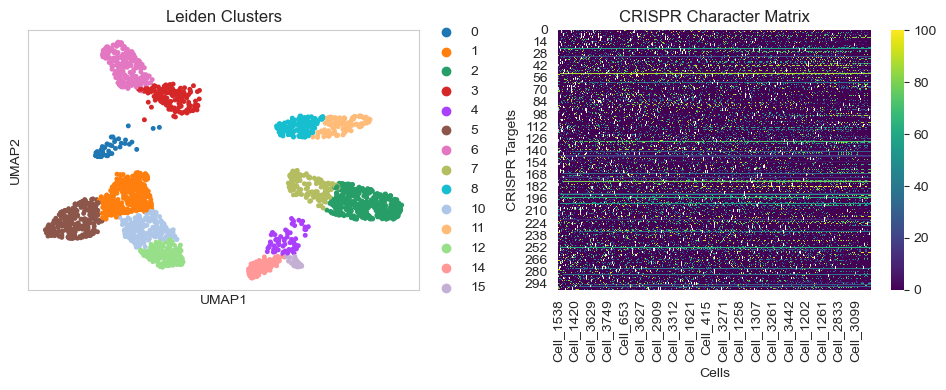

In [52]:
# Visualize the loaded data
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sc.pl.umap(ad, color='leiden', title='Leiden Clusters', size=50, ax=plt.gca(), show=False)

plt.subplot(1, 3, 2)
# Show character matrix sample
char_sample = character_matrix.replace(-1, np.nan)
sns.heatmap(char_sample.T, cmap='viridis', cbar=True)
plt.title('CRISPR Character Matrix')
plt.xlabel('Cells')
plt.ylabel('CRISPR Targets')

plt.tight_layout()
plt.show()

# Distance matrices

In order to compute neighborhoods, PLASTRO requires (1) lineage and (2) phenotypic cell-cell distance matrices. These distances can be based on any algorithm/input type that suits your data modality. For the purpose of this notebook, we will use the pairwise Hamming distance between cells for the CRISPR lineage tracing data and the Euclidean distance between cells in the latent phenotypic space.

In [53]:
# Load plastic data if available
plastic_datasets = {}

if os.path.exists(random_walk_plastic_path):
    print("Loading random walk plasticity data...")
    plastic_datasets['random_walk'] = sc.read_h5ad(random_walk_plastic_path)
    print(f"Random walk plastic data: {plastic_datasets['random_walk'].n_obs} cells, {plastic_datasets['random_walk'].n_vars} genes")

if os.path.exists(leiden_switch_plastic_path):
    print("Loading leiden switch plasticity data...")
    plastic_datasets['leiden_switch'] = sc.read_h5ad(leiden_switch_plastic_path)
    print(f"Leiden switch plastic data: {plastic_datasets['leiden_switch'].n_obs} cells, {plastic_datasets['leiden_switch'].n_vars} genes")

if not plastic_datasets:
    print("No plastic data found. Analysis will focus on original data only.")
else:
    print(f"Loaded {len(plastic_datasets)} plastic datasets for comparison.")

Loading random walk plasticity data...
Random walk plastic data: 2450 cells, 20 genes
Loading leiden switch plasticity data...
Leiden switch plastic data: 2450 cells, 20 genes
Loaded 2 plastic datasets for comparison.


# Overlap Computation

Overlaps are computed using the lineage distance matrix and phenotype distance matrix. You may do this manually if you want to compute custom distance relationships. By default, these methods are implemented with a modified Hamming distance for lineage data and Euclidean distance in the latent space for phenotype in the function `PLASTRO_overlaps()`. 

Under the hood, this implements:
```
# Compute distance matrices - replace with custom distance matrices as needed.
lineage_distances = compute_lineage_distances(character_matrix)
phenotype_distances = compute_phenotype_distances(ad_subset, latent_space_key)

radii = range(1, maximum_radius + 1, interval)

if parallel:
    # Parallel computation
    def compute_overlap_for_radius(radius):
        return compute_radius_overlaps(lineage_distances, phenotype_distances, radius)
    
    with multiprocessing.Pool() as pool:
        overlap_results = pool.map(compute_overlap_for_radius, radii)
else:
    # Sequential computation
    overlap_results = []
    for radius in tqdm(radii, desc="Computing overlaps"):
        overlap_results.append(
            compute_radius_overlaps(lineage_distances, phenotype_distances, radius)
        )

# Combine results
overlaps = pd.DataFrame(overlap_results, index=radii).T
overlaps.index = common_cells
```

In [54]:
overlaps = {}
for key in plastic_datasets:
    overlaps[key] = plastro.PLASTRO_overlaps(
        character_matrix=character_matrix,
        ad=plastic_datasets[key],
        latent_space_key='X_dc',
    )


Computing overlaps with maximum radius 500


Computing overlaps: 100%|██████████| 500/500 [00:25<00:00, 19.49it/s]


Computing overlaps with maximum radius 500


Computing overlaps: 100%|██████████| 500/500 [00:24<00:00, 20.01it/s]


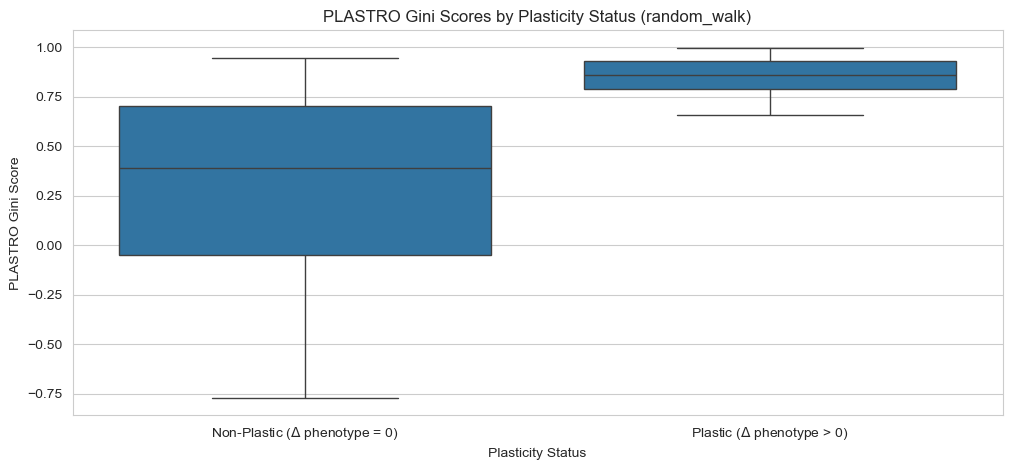

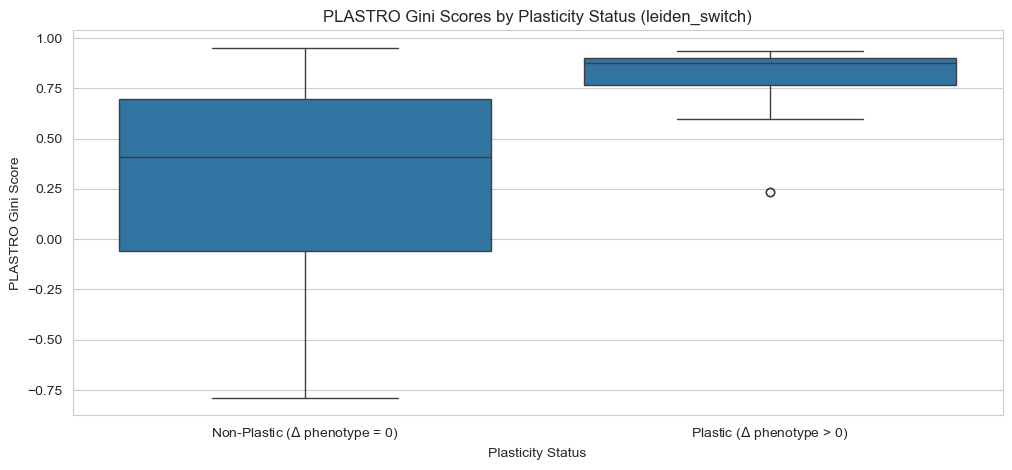

In [55]:
# Now we will visualize the distribution of PLASTRO scores for cells with plasticity (change_in_phenotype > 0) and those without (change_in_phenotype = 0).

PLASTRO_scores = {}
for key in overlaps:
    score = plastro.compute_gini_plasticity_score(overlaps[key])
    PLASTRO_scores[key] = score

    data = plastic_datasets[key].obs[['change_in_phenotype']].copy()
    data['gini_score'] = PLASTRO_scores[key]
    data['plastic'] = (data['change_in_phenotype'] > 0).astype(int)
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='plastic', y='gini_score', data=data)
    plt.xticks([0, 1], ['Non-Plastic ($\Delta$ phenotype = 0)', 'Plastic ($\Delta$ phenotype > 0)'])
    plt.title(f'PLASTRO Gini Scores by Plasticity Status ({key})')
    plt.ylabel('PLASTRO Gini Score')
    plt.xlabel('Plasticity Status')
    plt.show()

# Combined Workflow

We provide a convenience function `plastro.PLASTRO_score()` to combine these into a single step. See the documentation on readthedocs for more information.